In [1]:
import ira
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GridSearchCV, GroupKFold
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline

%alphalab dark

from alpha.utils.data_helpers import FriendlyFxLoader, make_forward_returns_matrix

from qlearn.core.pickers import SingleInstrumentPicker, PortfolioPicker
from qlearn.core.forward_returns import ForwardReturns, ForwardReturnsDirection, ForwardReturns3Classes
from qlearn.core.base import BasicMarketEstimator, MarketDataComposer
from qlearn.core.utils import crossup, crossdown, permutate_params

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


In [2]:
fxl = FriendlyFxLoader('dukas @ 5Min')
data = fxl.ohlcs(['EURUSD', 'GBPUSD', 'USDCHF'])
ext = fxl.externals(['EURUSD', 'GBPUSD'])

df1 = scols(*data.values(), keys=data.keys())
df2 = data
df3 = data['EURUSD']

In [ ]:
with DataSource('databank_ads::quotes') as ds:
    ticks = ds.load_data(['MT5_PROXY:NDXM', 'MT5_PROXY:ENQ', 'MT5_PROXY:EP'], '2020-11-19 00:00', '2020-12-03 12:00')

<hr/>
<h3>How to iterate through every symbol in market data</h3>
<hr/>

In [10]:
for s, v in SingleInstrumentPicker(timeframe='1d').for_range('2020-03-01').iterate(df1):
    print(s, v)
    print('[red]===================')

<hr/>
<h3>How to iterate through whole portfolio of symbols</h3>
<hr/>

In [ ]:
for s, v in PortfolioPicker(timeframe='1d').iterate(df1):
    print(s)
    print(v)

In [ ]:
v

<hr/>
<h3>Forward returns producers</h3>
<hr/>

In [ ]:
print(ForwardReturns(horizon=1, returns_type='pips', tick_size=1e-5).transform(ohlc_resample(df3, '1d'), None))
print(ForwardReturns3Classes(horizon=1, tick_size=1e-5, tick_tolerance=500).transform(ohlc_resample(df3, '1d'), None))

<hr/>
<h3>Simple entry (rsi indicator)</h3>
<hr/>

In [5]:
class RsiEntry(BasicMarketEstimator):
    def __init__(self, period, low=15, up=85):
        self.period = period
        self.low = low
        self.up = up

    def fit(self, X, y, **fit_params):
        return self

    def predict(self, X):
        meta = self.metadata()
        r = rsi(X[meta.column], self.period)
        sigs = pd.Series(0, r.index)
        sigs.loc[crossup(r, self.low)] = +1
        sigs.loc[crossdown(r, self.up)] = -1
        return sigs.astype(int)

In [ ]:
m1 = RsiEntry(14, 25, 75)
print(m1.predict(df1.GBPUSD))

<hr/>
<h3>How to attach additional data</h3>
<hr/>

In [6]:
class MidDayCalculator(TransformerMixin):
    def fit(self, x, y, **kwargs):
        return self
    
    def transform(self, x):
        return x.assign(middle = 0.5*(x.low + x.high)).shift(1)

In [ ]:
c1 = MidDayCalculator()
c1.transform(df1.EURUSD)

In [ ]:
m1 = make_pipeline(MidDayCalculator(), RsiEntry(16, 20, 80))
print(m1.predict(df1.EURUSD))

<hr/>
<h3>Market data composer</h3>
<hr/>

In [7]:
m1 = RsiEntry(10, 20, 80)
c1 = MarketDataComposer(m1, SingleInstrumentPicker(tz='EET'), None, 'close', '1D')

print(c1.fit(df2, None).predict(df2))

In [8]:
m1 = make_pipeline(MidDayCalculator(), RsiEntry(10, 10, 90).as_classifier())

g1 = GridSearchCV(
    cv = TimeSeriesSplit(3),
    estimator = m1,
    param_grid={ 
        'rsientry__period': np.arange(7, 16), 
        'rsientry__low': [10, 20, 25], 
        'rsientry__up': [90, 80, 75], 
    },
)

mds = MarketDataComposer(g1, 
                         SingleInstrumentPicker(tz='EET'), 
                         ForwardReturns3Classes(horizon=1, tick_size=1e-5, tick_tolerance=25), 
                         'close', '5Min', debug=False
                        )

In [9]:
b = mds.fit(df1, None)

In [10]:
b.best_params_

{'USDCHF': {'rsientry__low': 10, 'rsientry__period': 15, 'rsientry__up': 90},
 'GBPUSD': {'rsientry__low': 10, 'rsientry__period': 15, 'rsientry__up': 90},
 'EURUSD': {'rsientry__low': 10, 'rsientry__period': 15, 'rsientry__up': 90}}

In [11]:
b.best_score_

{'USDCHF': 0.7636150945544798,
 'GBPUSD': 0.6004638005243638,
 'EURUSD': 0.7209429313789427}

In [ ]:
b.picker.rules = []
b.predict(df1)
# b.predict(df1[['GBPUSD']])

In [ ]:
b.picker.rules = []
b.predict(df1)
# b.predict(df1[['GBPUSD']])

In [ ]:
r01 = z_backtest(shift_signals(b.predict(df2), '4M59S'), df2, 'forex', spread=1e-5)

In [ ]:
tearsheet(r01.portfolio, 1)

<hr/>
<h3>Complex strategy with predictors</h3>
<hr/>

In [16]:
class TestComplex(BasicMarketEstimator):
    def __init__(self, period, adx_threshold=15, s1=RsiEntry(10, 20, 80)):
        self.period = period
        self.adx_threshold = adx_threshold
        self.s1 = s1

    def fit(self, X, y, **fit_params):
        meta = self.metadata()
        return self

    def predict(self, X):
        d = adx(X, self.period, smoother='sma', as_frame=True)
        p = self.s1.predict(X)
        
        p[d.ADX < self.adx_threshold] = 0
        p[(p > 0) & (X.middle < X.close)] = 0
        p[(p < 0) & (X.middle > X.close)] = 0
        return p

In [17]:
g1 = GridSearchCV(
        n_jobs = 5,
        cv = TimeSeriesSplit(3),
        estimator = make_pipeline(make_pipeline(MidDayCalculator()), TestComplex(10).as_classifier()),
        param_grid = permutate_params({ 
            'testcomplex__period': np.arange(25, 150, 10), 
            'testcomplex__adx_threshold': [10, 15, 20, 25], 
            'testcomplex__s1__period': np.arange(3, 15), 
            'testcomplex__s1__low': [10, 15, 20, 25], 
            'testcomplex__s1__up': [90, 85, 80, 75],
        }, conditions=lambda testcomplex__s1__low, testcomplex__s1__up: testcomplex__s1__low + testcomplex__s1__up==100),
        verbose=1
    )

ms1 = MarketDataComposer(g1, 
                         SingleInstrumentPicker(tz='EET'), 
                         ForwardReturnsDirection(horizon=1), 
                         'close', '1D', debug=False
                        )

In [18]:
b1 = ms1.fit(df1, None)

Fitting 3 folds for each of 2496 candidates, totalling 7488 fits
Fitting 3 folds for each of 2496 candidates, totalling 7488 fits
Fitting 3 folds for each of 2496 candidates, totalling 7488 fits



In [19]:
b1.best_params_, b1.best_score_

({'USDCHF': {'testcomplex__adx_threshold': 10,
   'testcomplex__period': 25,
   'testcomplex__s1__low': 25,
   'testcomplex__s1__period': 5,
   'testcomplex__s1__up': 75},
  'GBPUSD': {'testcomplex__adx_threshold': 10,
   'testcomplex__period': 25,
   'testcomplex__s1__low': 25,
   'testcomplex__s1__period': 3,
   'testcomplex__s1__up': 75},
  'EURUSD': {'testcomplex__adx_threshold': 10,
   'testcomplex__period': 25,
   'testcomplex__s1__low': 20,
   'testcomplex__s1__period': 3,
   'testcomplex__s1__up': 80}},
 {'USDCHF': 0.01391941391941392,
  'GBPUSD': 0.018315018315018316,
  'EURUSD': 0.011721611721611722})

2021-02-08 11:18:13,043 - ira.simulator.SignalTester - WARNING - Can't find prices for signals at time [2020-11-26 23:59:00.001000]


Statistic,Model
Gain (USD):,-0.09
CAGR (%):,-0.000
Sharpe:,-0.306
Sortino:,-0.378
Calmar:,-0.070
MaxDD (%):,0.001
MaxDD On Init BP (%):,0.001
MaxDD (USD):,0.129
MaxDD days:,2365 days
MaxDD start:,2014-06-06

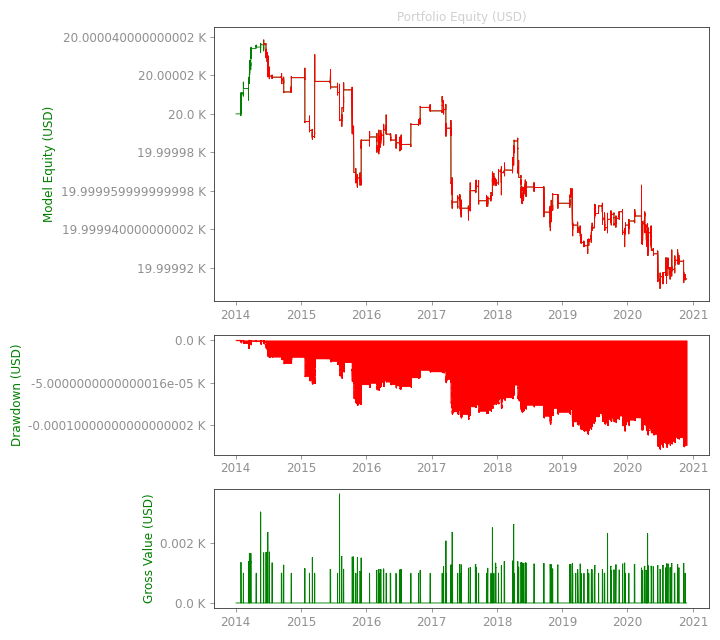

<Figure size 720x640 with 0 Axes>

In [20]:
p0 = z_test_signals_inplace(shift_signals(b1.predict(df1), hours=23), df2, 'forex', spread=0, verbose=False)
tearsheet(p0, 20000)

<hr/>
<h3>Scoring functions</h3>
<hr/>

In [28]:
from qlearn.core.utils import debug_output

In [7]:
def scoring1(p_set, ypred, y):
    print(p_set)
    debug_output(ypred.head(), 'Pred')
    debug_output(y.head(), 'Y')
    return 0

In [8]:
g2 = GridSearchCV(
        cv=TimeSeriesSplit(3),
        estimator = make_pipeline(
            MidDayCalculator(),
            TestComplex(10)
        ),
        scoring=scoring1,
        param_grid = permutate_params({ 
            'testcomplex__period': np.arange(25, 150, 10), 
            'testcomplex__adx_threshold': [10, 15, 20, 25], 
            'testcomplex__s1__period': np.arange(3, 15), 
            'testcomplex__s1__low': [10, 15, 20, 25], 
            'testcomplex__s1__up': [90, 85, 80, 75],
        }, conditions=lambda testcomplex__s1__low, testcomplex__s1__up: testcomplex__s1__low + testcomplex__s1__up==100),
        verbose=1
    )

ms2 = MarketDataComposer(g2, 
                         SingleInstrumentPicker(tz='EET'), 
                         ForwardReturnsDirection(horizon=1), 
                         'close', '1D', debug=False
                        )

In [ ]:
b2 = ms2.fit(df1, None)

<hr/>
<h3>Multi instrument strategy (portfolio)</h3>
<hr/>

In [6]:
import seaborn as sns

In [7]:
sxl = FriendlyFxLoader('nyse @ daily')
md = sxl.ohlcs(sxl.symbols())

In [50]:
class PairsTrader(BasicMarketEstimator):
    def __init__(self, period, z_period, pctls=5, nstd=None):
        self.period = period
        self.z_period = z_period
        self.pctls = pctls
        self.nstd = nstd
        
    def calc_z(self, x, y):
        s = x - y
        m = apply_to_frame(sma, s, self.period)
        ds = s - apply_to_frame(sma, s, self.period)
        return ds / ds.rolling(window=self.z_period, min_periods=self.z_period).std()

    def fit(self, X, y, **fit_params):
        s1, s2, *_ = self.metadata().symbols
        closes = X.xs('close', axis=1, level=1)
        zs = self.calc_z(closes[s1], closes[s2])
        if self.nstd is None:
            self.zb_, self.zt_ = np.percentile(zs.dropna(), sorted([self.pctls, 100-self.pctls]))
        else:
            self.zb_, self.zt_ = self.nstd, -self.nstd
        print(self.zb_, self.zt_)
        
        return self

    def predict(self, X):
        s1, s2, *_ = self.metadata().symbols
        closes = X.xs('close', axis=1, level=1)
        
        zs = self.calc_z(closes[s1], closes[s2])
        s_entries = crossdown(zs, self.zt_)
        l_entries = crossup(zs, self.zb_)
        
        short_spread = pd.DataFrame({s1: -1, s2: +1 }, s_entries)
        short_ex = None #pd.DataFrame({s1: 0, s2: 0 }, crossdown(zs, 0.5))
        
        long_spread = pd.DataFrame({s1: +1, s2: -1 }, l_entries)
        long_ex = None #pd.DataFrame({s1: 0, s2: 0 }, crossup(zs, -0.5))
        
        plt.plot(zs); plt.plot(zs.loc[s_entries], 'r.', ms=4);  plt.plot(zs.loc[l_entries], 'g.', ms=4)
        plt.axhline(self.zt_); plt.axhline(self.zb_)
        
        return srows(long_spread, long_ex, short_spread, short_ex).sort_index()

In [62]:
p_trader = PairsTrader(5, 20, 5)

fm = MarketDataComposer(p_trader, PortfolioPicker(['DHI$', 'PHM$']).for_range('2006'), None, 'close').fit(md, pd.Series(0))

Statistic,Model
Gain (USD):,65630.00
CAGR (%):,10.161
Sharpe:,0.782
Sortino:,1.195
Calmar:,0.495
MaxDD (%):,17.313
MaxDD On Init BP (%):,47.100
MaxDD (USD):,9420.000
MaxDD days:,220 days
MaxDD start:,2017-09-12

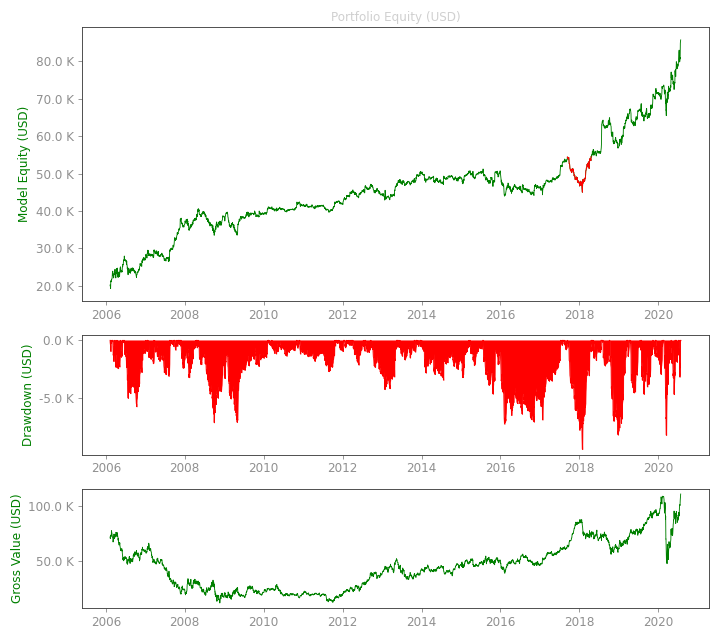

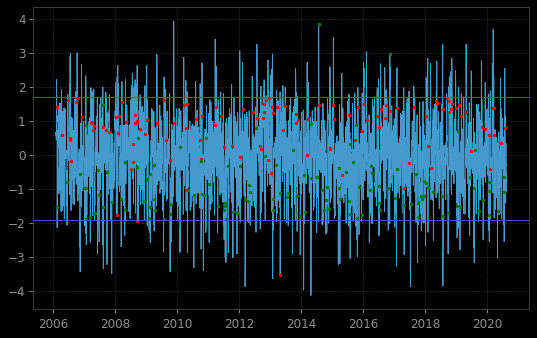

<Figure size 720x640 with 0 Axes>

In [63]:
p0 = z_test_signals_inplace(1000*fm.predict(md), md, 'stock', spread=0.1, verbose=False)
tearsheet(p0, 20000)

In [307]:
c_table = mc.corr()

# New last approach

In [4]:
s0 = q.SingleInstrumentComposer(CrossingMovings(15, 50)).fit(data1m, None)
s1 = q.SingleInstrumentComposer(Rsi(15)).fit(data1m, None)
s2 = q.SingleInstrumentComposer(AdxFilter('5Min', 20, 25, 'ema')).fit(data1m, None)

In [5]:
q.ls_params(s0.predictor)

{
	'fast': [15],
	'fast_type': ['sma'],
	'slow': [50],
	'slow_type': ['sma']
}


In [ ]:
# plt.plot(t5.predict(data1m))

In [5]:
tF = q.SingleInstrumentComposer(
    q.make_pipeline(FractalsRange('1Min', 1), q.Imply(
        q.Imply(
            CrossingMovings(15, 50), RangeBreakoutDetector()
        ), 
        Rsi(15)))).fit(data1m, None)

t1 = q.SingleInstrumentComposer(CrossingMovings(15, 50)).fit(data1m, None)

t2 = q.SingleInstrumentComposer(q.make_pipeline(FractalsRange('1Min', 1), RangeBreakoutDetector())).fit(data1m, None)

t12 = q.SingleInstrumentComposer(q.make_pipeline(FractalsRange('1Min', 1), CrossingMovings(15, 50) >> RangeBreakoutDetector())).fit(data1m, None)

t3 = q.SingleInstrumentComposer(Rsi(15)).fit(data1m, None)

t4 = q.SingleInstrumentComposer(Rsi(15) & AdxFilter('5Min', 20, 25, 'ema')).fit(data1m, None)

t5 = q.SingleInstrumentComposer(Rsi(15) &  AdxFilter('15Min', 20, 25, 'ema') & VolatilityFilter('1Min', 60, 600)).fit(data1m, None)

t6 = q.SingleInstrumentComposer(
    (CrossingMovings(15, 150) >> Rsi(15, 15, 85)) & AdxFilter('15Min', 20, 25, 'ema') & VolatilityFilter('1Min', 60, 600)
).fit(data1m, None)

In [ ]:
r0 = q.simulation({
    'xMA -> Breaks(f) -> RSI': tF,
    'xMA': t1,
    'Breaks(f)': t2,
    'xMA -> Breaks(f)': t12,
    'RSI': t3,
    'RSI & AdxFilter': t4,
    'RSI & AdxFilter & VolatilityFilter': t5,
    'xMA -> RSI & AdxFilter & VolatilityFilter': t6,
}, d.datas('1Min'), 'crypto_futures', 'TestProject', spreads=1)

TestProject/xMA -> Breaks(f) -> RSI                    : Sharpe: 3.51 | Sortino: 6.35 | CAGR: 639.82 | DD: $0.20 (13.56%) | Gain: $1.46 | Execs: 367[OK]
TestProject/xMA                                        : Sharpe: -1.15 | Sortino: -1.72 | CAGR: -83.60 | DD: $0.52 (49.47%) | Gain: $0.71 | Execs: 2639[OK]
TestProject/Breaks(f)                                  : Sharpe: 3.34 | Sortino: 6.27 | CAGR: 882.99 | DD: $0.22 (22.01%) | Gain: $1.55 | Execs: 5287[OK]
TestProject/xMA -> Breaks(f)                           : Sharpe: -inf | Sortino: -8.06 | CAGR: -99.99 | DD: $0.71 (68.21%) | Gain: $0.54 | Execs: 1088[OK]
TestProject/RSI                                        : Sharpe: 3.71 | Sortino: 6.39 | CAGR: 531.51 | DD: $0.25 (15.27%) | Gain: $1.42 | Execs: 1071[OK]
TestProject/RSI & AdxFilter                            : Sharpe: -0.28 | Sortino: -0.49 | CAGR: -50.97 | DD: $0.35 (31.50%) | Gain: $0.87 | Execs: 152[OK]
TestProject/RSI & AdxFilter & VolatilityFilter         : Sharpe: 0.36 | S

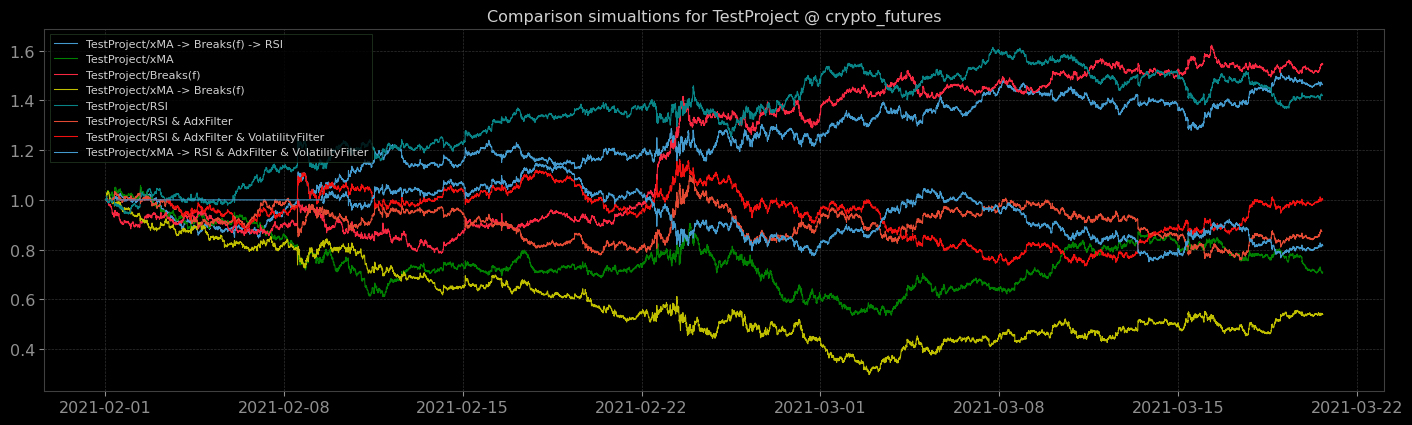

In [8]:
fig(18, 5)
q.simulations_report(r0, 1)

In [9]:
q.ls_params(tF.predictor)

{
	'fractalsrange__nf': [1],
	'fractalsrange__timeframe': ['1Min'],
	'fractalsrange__tz': ['UTC'],
	'imply__first__first__fast': [15],
	'imply__first__first__fast_type': ['sma'],
	'imply__first__first__slow': [50],
	'imply__first__first__slow_type': ['sma'],
	'imply__first__second__threshold': [0],
	'imply__second__lower': [25],
	'imply__second__period': [15],
	'imply__second__smoother': ['sma'],
	'imply__second__upper': [75]
}


In [10]:
_z = slice('2021-02-01 00:00', '2021-02-01 5:00')
y1 = t1.predict(data1m)[_z]
y2 = 2*t2.predict(data1m)[_z]
y12 = 3*t12.predict(data1m)[_z]
y3 = 4*t3.predict(data1m)[_z]
yF = 6*tF.predict(data1m)[_z]

In [ ]:
TF = scols(y1, y2, y3, y12, yF, names=['l1', 'l2', 'l3', 'l1+l2', 'F'])
TF[~TF.F.isnull()]

In [ ]:
fig(18, 5)
plt.step(y1.index, y1, label='Lead 1', where='post'); plt.plot(y1.index, y1, '.', ms=10)
plt.step(y2.index, y2, label='Lead 2', where='post'); plt.plot(y2.index, y2, '.', ms=10)
plt.step(y12.index, y12, label='Lead 1+2', lw=2, where='post'); plt.plot(y12.index, y12, '.', ms=10)
plt.step(y3.index, y3, label='Lead 3', where='post'); plt.plot(y3.index, y3, '.', ms=10)

plt.step(yF.index, yF*3, label='Final', where='post', ls='--'); plt.plot(yF.index, yF*3, '.', ms=10)
plt.axhline(0, ls='--'); plt.legend();

In [12]:
sx = q.simulation([t1, q.PipelineTracker(q.TimeExpirationTracker('1h'), q.FixedTrader(1000, 500, 400))], data1m, 'crypto_futures', 'T1')

T1  : Sharpe: 0.43 | Sortino: 0.72 | CAGR: 5.94 | DD: $286.82 (27.76%) | Gain: $1011.84 | Execs: 3209[OK]


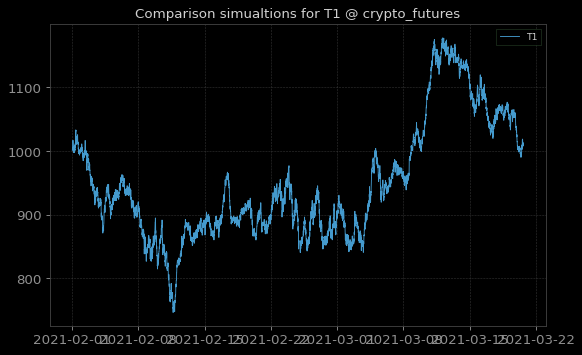

In [13]:
q.simulations_report(sx, 1000)

In [14]:
sx.results[0].trackers_stat

{'XBTUSD': {'expired': 69,
  'expired_profitable': 60,
  'expired_loss': 9,
  'takes': 252,
  'stops': 249,
  'average_time_to_take': Timedelta('0 days 00:21:48'),
  'average_time_to_stop': Timedelta('0 days 00:16:21.722891566')}}

In [ ]:
data1m

In [ ]:
plt.plot(S(f0))
plt.plot(S(f1))

plt.plot(S(And(f0, q.Neg(f1)))* 1.1, '--')